# Setup

In [1]:
from ultralytics import YOLO, RTDETR
from matplotlib import pyplot as plt
import cv2
import torch
import os
import numpy as np
import random
import json
import sys
from datetime import datetime

# os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1, 2, 3" # replace with the GPU IDs that are available

# to help with reproducibility
seed=0
import torch.backends.cudnn as cudnn 
random.seed(seed) 
np.random.seed(seed) 
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)   
cudnn.benchmark, cudnn.deterministic = False, True

from xami_model.model_predictor import predictor_utils, xami, residualAttentionBlock
from xami_model.losses import metrics_utils
from xami_model.dataset import dataset_utils

In [2]:
kfold_iter=0

device_id=0
batch_size=8
lr=3e-5
wd=0.0005
wandb_track=True
torch.cuda.set_device(device_id)
datetime_now = datetime.now()

if wandb_track:
    # !pip install wandb
    # !wandb login
    import wandb
    wandb.login()
    run = wandb.init(project="yolo-sam", name=f"yolo-sam {datetime_now}")

wandb: Currently logged in as: iuliaelisa15. Use `wandb login --relogin` to force relogin


In [3]:
yolo_dataset_path = './xami_dataset_zip/xami_dataset_yolov8/'
coco_data_path = './xami_dataset_zip/xami_dataset_coco/'
annotations_file = '_annotations.coco.json'

In [4]:
import yaml

with open(yolo_dataset_path+f"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dictionary with keys 'names', 'nc', 'train', 'val'

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
print('Clases:', classes)

with open(coco_data_path+'train/'+annotations_file, 'r') as f1, open(coco_data_path+'valid/'+annotations_file, 'r') as f2:
    train_coco_data = json.load(f1)
    valid_coco_data = json.load(f2)
    
train_dir = yolo_dataset_path+f'train/images/'
valid_dir = yolo_dataset_path+f'valid/images/'

train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)

Clases: {0: 'central-ring', 1: 'other', 2: 'read-out-streak', 3: 'smoke-ring', 4: 'star-loop'}


## Model setup

In [5]:
from xami_model.mobile_sam.mobile_sam import sam_model_registry, SamPredictor

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
mobile_sam_checkpoint = './weights/sam_weights/sam_0_best.pth'

detector_pretrained_model = YOLO(f'./weights/yolo_weights/yolov8_detect_300e_last.pt');
# detector_pretrained_model = YOLO(f'./yolov8-segm-0/yolov8n-seg23/weights/last.pt');
# detector_pretrained_model = RTDETR(f'./rt-detr-iter0/rtdetr-l4/weights/best.pt');

detector_pretrained_model.to(device);
mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

In [6]:
# xami_model = xami.XAMI(mobile_sam_model, device, predictor)
xami_model = xami.XAMI(
    mobile_sam_model, 
    device, 
    predictor, 
    use_yolo_masks=True, 
    wt_threshold=0.6, 
    wt_classes_ids = [1.0, 4.0])

In [7]:
for name, param in mobile_sam_model.named_parameters():
    if 'mask_decoder' in name: 
        param.requires_grad = True
    else:
        param.requires_grad = False
        
print(f"🚀 The model has {sum(p.numel() for p in xami_model.model.parameters() if p.requires_grad)} trainable parameters.")

🚀 The model has 4058340 trainable parameters.


In [8]:
import tqdm
from tqdm import tqdm

train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size
parameters_to_optimize = [param for param in mobile_sam_model.mask_decoder.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(parameters_to_optimize, lr=lr, weight_decay=wd) if len(parameters_to_optimize) > 0 else None

## Define metrics

In [9]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric_thresholds = [[0.5], [0.75], [0.5, 0.9]]

# Train

In [10]:
from collections import defaultdict

best_valid_loss = float('inf')
num_epochs = 10
n_epochs_stop = num_epochs // 10 + 5
all_metrics = defaultdict(dict)
compute_metrics = True

In [11]:
# Intro
predictor_utils.print_training_intro(
    train_image_files, valid_image_files, device, metric_thresholds, num_epochs, 
    batch_size, lr, wd, wandb_track, mobile_sam_model, 'AdamW')

# Training loop
for epoch in range(num_epochs):

    # Train
    xami_model.model.train()
    train_results = xami_model.run_yolo_sam_epoch(
        detector_pretrained_model,
        phase='train',
        batch_size=batch_size, 
        image_files=train_image_files, 
        images_dir=train_dir, 
        num_batches=train_num_batches,
        optimizer=optimizer) 
    
    epoch_sam_loss_train, train_preds, train_gts = train_results[:3]
    train_gt_classes, train_pred_classes, train_iou_scores, train_mask_areas, train_pred_images, t_all_preds = train_results[3:]

    # Validate
    xami_model.model.eval()
    with torch.no_grad():
        valid_results = xami_model.run_yolo_sam_epoch(
            detector_pretrained_model,
            phase='val',
            batch_size=batch_size, 
            image_files=valid_image_files, 
            images_dir=valid_dir, 
            num_batches=valid_num_batches,
            optimizer=None) 

    epoch_sam_loss_val, valid_preds, valid_gts = valid_results[:3]
    valid_gt_classes, valid_pred_classes, valid_iou_scores, valid_mask_areas, pred_images, v_all_preds = valid_results[3:]

    # Early stopping                                                                                
    if epoch_sam_loss_val < best_valid_loss:
        best_valid_loss = epoch_sam_loss_val
        best_model = xami_model.model
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping initiated.")
            early_stop = True
            break
        
    # Metrics
    if compute_metrics:
        for threshold in tqdm(metric_thresholds, desc="(Metrics) Processing thresholds", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
            metric = MeanAveragePrecision(
            iou_type = "segm", 
            iou_thresholds = threshold, 
            max_detection_thresholds=None,
            class_metrics=True,
            extended_summary=False)
            
            train_metrics = metrics_utils.mAP_metrics(metric,
            train_preds,
            train_gts, 
            train_gt_classes, 
            train_pred_classes, 
            train_iou_scores,
            train_mask_areas,
            show_metrics=False) 
                
            valid_metrics = metrics_utils.mAP_metrics(metric,
            valid_preds,
            valid_gts, 
            valid_gt_classes, 
            valid_pred_classes, 
            valid_iou_scores,
            valid_mask_areas,
            show_metrics=False)
        
            all_metrics[tuple(threshold)] = {'train': train_metrics, 'valid': valid_metrics}

        # Prints
        if not wandb_track:
            wandb = None

        if compute_metrics:
            predictor_utils.prints_and_wandb(
                epoch, 
                epoch_sam_loss_train, 
                epoch_sam_loss_val, 
                all_metrics, 
                metric_thresholds,
                wandb)
            
# Checkpoint save
# torch.save(xami_model.model.state_dict(), f'./output_sam_test/yolo_sam_final.pth')

Model Training Configuration:
 - Training images: 791
 - Validation images: 264
 - Number of Epochs: 10
 - Batch Size: 8
 - Learning Rate: 3e-05
 - Weight Decay: 0.0005
 - Device: cuda:0
 - mAP thresholds: [[0.5], [0.75], [0.5, 0.9]]
 - Early Stopping: Stop if no improvement after 6 epochs.
 - Weights & Biases Tracking: Enabled.
 - Optimizer: AdamW.
 - Total Trainable Parameters: 4,058,340


Val Progress:  18%|█▊        | 6/33 [00:08<00:35,  1.32s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:34<00:00, 11.66s/it]                                                       


Train mAP[0.5]: 93.69999694824219. Valid mAP[0.5]: 88.80000305175781
Train mAP[0.75]: 73.5999984741211. Valid mAP[0.75]: 68.30000305175781
Train mAP[0.5, 0.9]: 56.29999923706055. Valid mAP[0.5, 0.9]: 52.70000076293945
Epoch 0. Train loss: 1.1374037
Epoch 0. Validation loss: 1.210944


Val Progress:  18%|█▊        | 6/33 [00:08<00:36,  1.35s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:35<00:00, 11.87s/it]                                                       


Train mAP[0.5]: 94.0. Valid mAP[0.5]: 89.19999694824219
Train mAP[0.75]: 76.0999984741211. Valid mAP[0.75]: 70.5999984741211
Train mAP[0.5, 0.9]: 57.29999923706055. Valid mAP[0.5, 0.9]: 53.599998474121094
Epoch 1. Train loss: 1.1309316
Epoch 1. Validation loss: 1.2102789


Val Progress:  18%|█▊        | 6/33 [00:08<00:36,  1.33s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:35<00:00, 11.73s/it]                                                       


Train mAP[0.5]: 95.0. Valid mAP[0.5]: 90.19999694824219
Train mAP[0.75]: 77.0. Valid mAP[0.75]: 71.0999984741211
Train mAP[0.5, 0.9]: 58.20000076293945. Valid mAP[0.5, 0.9]: 54.29999923706055
Epoch 2. Train loss: 1.1274462
Epoch 2. Validation loss: 1.2098374


Val Progress:  18%|█▊        | 6/33 [00:08<00:36,  1.36s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:35<00:00, 11.81s/it]                                                       


Train mAP[0.5]: 94.9000015258789. Valid mAP[0.5]: 90.0
Train mAP[0.75]: 77.69999694824219. Valid mAP[0.75]: 71.80000305175781
Train mAP[0.5, 0.9]: 58.20000076293945. Valid mAP[0.5, 0.9]: 54.29999923706055
Epoch 3. Train loss: 1.1247622
Epoch 3. Validation loss: 1.2103859


Val Progress:  18%|█▊        | 6/33 [00:09<00:37,  1.38s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:34<00:00, 11.58s/it]                                                       


Train mAP[0.5]: 94.9000015258789. Valid mAP[0.5]: 90.0999984741211
Train mAP[0.75]: 78.0. Valid mAP[0.75]: 72.0999984741211
Train mAP[0.5, 0.9]: 58.70000076293945. Valid mAP[0.5, 0.9]: 54.599998474121094
Epoch 4. Train loss: 1.1228433
Epoch 4. Validation loss: 1.2105403


Val Progress:  18%|█▊        | 6/33 [00:13<00:51,  1.90s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:35<00:00, 11.86s/it]                                                       


Train mAP[0.5]: 95.0. Valid mAP[0.5]: 90.30000305175781
Train mAP[0.75]: 78.4000015258789. Valid mAP[0.75]: 72.5999984741211
Train mAP[0.5, 0.9]: 59.20000076293945. Valid mAP[0.5, 0.9]: 55.099998474121094
Epoch 5. Train loss: 1.1206846
Epoch 5. Validation loss: 1.2097431


Val Progress:  18%|█▊        | 6/33 [00:13<00:51,  1.90s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:35<00:00, 11.77s/it]                                                       


Train mAP[0.5]: 95.0. Valid mAP[0.5]: 90.0999984741211
Train mAP[0.75]: 79.0999984741211. Valid mAP[0.75]: 72.69999694824219
Train mAP[0.5, 0.9]: 59.599998474121094. Valid mAP[0.5, 0.9]: 55.29999923706055
Epoch 6. Train loss: 1.1190557
Epoch 6. Validation loss: 1.2099084


Val Progress:  18%|█▊        | 6/33 [00:13<00:52,  1.93s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:35<00:00, 11.88s/it]                                                       


Train mAP[0.5]: 95.4000015258789. Valid mAP[0.5]: 90.5999984741211
Train mAP[0.75]: 79.9000015258789. Valid mAP[0.75]: 73.5
Train mAP[0.5, 0.9]: 60.099998474121094. Valid mAP[0.5, 0.9]: 55.79999923706055
Epoch 7. Train loss: 1.1177552
Epoch 7. Validation loss: 1.2103817


Val Progress:  18%|█▊        | 6/33 [00:13<00:53,  2.00s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:36<00:00, 12.01s/it]                                                       


Train mAP[0.5]: 95.0999984741211. Valid mAP[0.5]: 90.19999694824219
Train mAP[0.75]: 80.0. Valid mAP[0.75]: 73.5999984741211
Train mAP[0.5, 0.9]: 60.099998474121094. Valid mAP[0.5, 0.9]: 55.599998474121094
Epoch 8. Train loss: 1.1163462
Epoch 8. Validation loss: 1.21015


Val Progress:  18%|█▊        | 6/33 [00:14<00:55,  2.04s/it]                                                                         

NONzero predictions, zero GT masks.
S0018141301_M_png_jpg.rf.1448fa053d716ddcd90a132948159d53.jpg


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:35<00:00, 11.96s/it]                                                       

Train mAP[0.5]: 95.30000305175781. Valid mAP[0.5]: 90.30000305175781
Train mAP[0.75]: 80.5. Valid mAP[0.75]: 73.69999694824219
Train mAP[0.5, 0.9]: 60.70000076293945. Valid mAP[0.5, 0.9]: 56.0
Epoch 9. Train loss: 1.1150916
Epoch 9. Validation loss: 1.2100791


# Performance evaluation

In [13]:
# Finish wandb run
if wandb_track:
    run.finish()
        
if compute_metrics:   
    metrics_dict = defaultdict(dict)
    metrics_dict[f'{metric_thresholds[0][0]}'] = predictor_utils.convert_tensors(all_metrics[tuple(metric_thresholds[0])])
    metrics_dict[f'{metric_thresholds[1][0]}'] = predictor_utils.convert_tensors(all_metrics[tuple(metric_thresholds[1])])
    metrics_dict[f'{metric_thresholds[2][0]}-{metric_thresholds[2][1]}'] = predictor_utils.convert_tensors(all_metrics[tuple(metric_thresholds[2])])
    metrics_dict['best_epoch'] = best_epoch
    
    with open(f'metrics_{datetime_now}.json', 'w') as json_file:
        json.dump(metrics_dict, json_file, indent=4)

**Ious between all preds and GTs per image, averaged**

In [14]:
# train_ious_in_image, valid_ious_in_image = [], []

# for img_i in range(len(train_pred_images)):
#     for (gts_m, preds_m) in zip(t_abs_preds, train_gts):
#         _, _, _, iou_in_image = metrics_utils.compute_metrics_with_range(gts_m, preds_m)
#         train_ious_in_image.append(iou_in_image)
        
# for img_i in range(len(pred_images)):
#     for (gts_m, preds_m) in zip(v_abs_preds, valid_gts):
#         _, _, _, iou_in_image = metrics_utils.compute_metrics_with_range(gts_m, preds_m)
#         print(iou_in_image)
#         valid_ious_in_image.append(iou_in_image)

In [18]:
# np.mean(train_ious_in_image), np.std(train_ious_in_image)
# np.mean(valid_ious_in_image), np.std(valid_ious_in_image)

**Ious between all preds and GTs aligned**

In [19]:
train_ious_pred_vs_gt_flatten, train_ious_pred_vs_gt = metrics_utils.ious_pred_vs_gt(train_gts, train_preds)
valid_ious_pred_vs_gt_flatten, valid_ious_pred_vs_gt = metrics_utils.ious_pred_vs_gt(valid_gts, valid_preds)

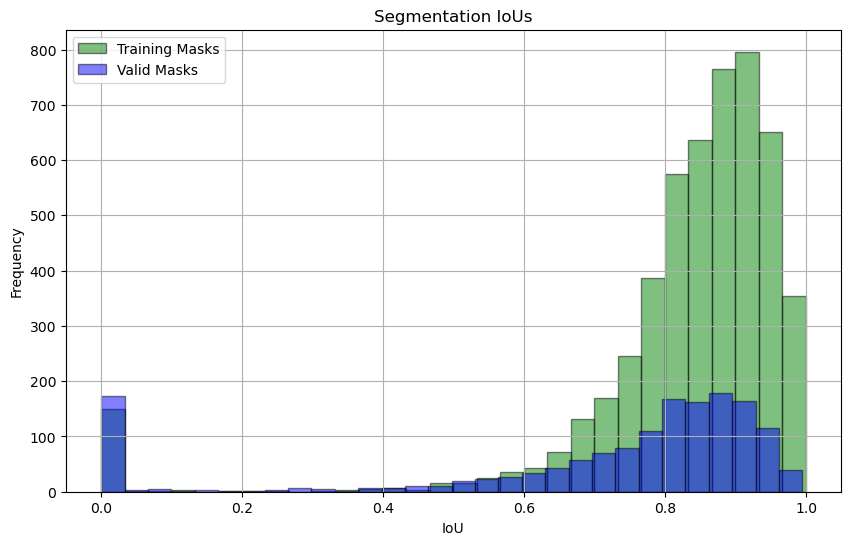

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(train_ious_pred_vs_gt_flatten, bins=30, alpha=0.5, color='green', edgecolor='black', label='Training Masks')
plt.hist(valid_ious_pred_vs_gt_flatten, bins=30, alpha=0.5, color='blue', edgecolor='black', label='Valid Masks')

plt.title('Segmentation IoUs')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

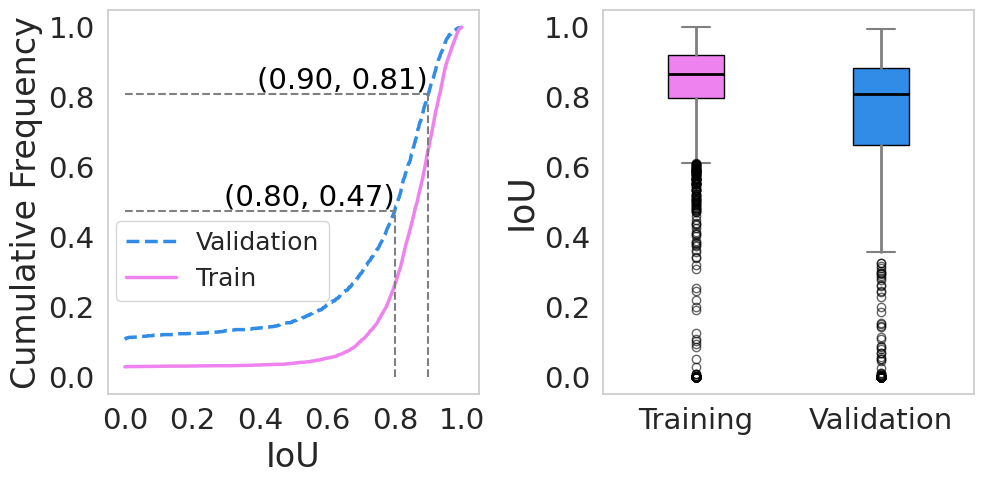

In [21]:
metrics_utils.plot_ious(train_ious_pred_vs_gt_flatten, valid_ious_pred_vs_gt_flatten, box_anchor=(0.63, 0.21))

In [22]:
np.min(train_ious_pred_vs_gt_flatten), np.max(train_ious_pred_vs_gt_flatten), \
np.min(valid_ious_pred_vs_gt_flatten), np.max(valid_ious_pred_vs_gt_flatten)

(0.0, 0.9988962472406181, 0.0, 0.9940953184310417)

In [23]:
np.mean(train_ious_pred_vs_gt_flatten), np.std(valid_ious_pred_vs_gt_flatten), \
np.mean(valid_ious_pred_vs_gt_flatten), np.std(valid_ious_pred_vs_gt_flatten)

(0.825855879930418, 0.2885591992459024, 0.698254119193619, 0.2885591992459024)

### IoU TP FP FN plot

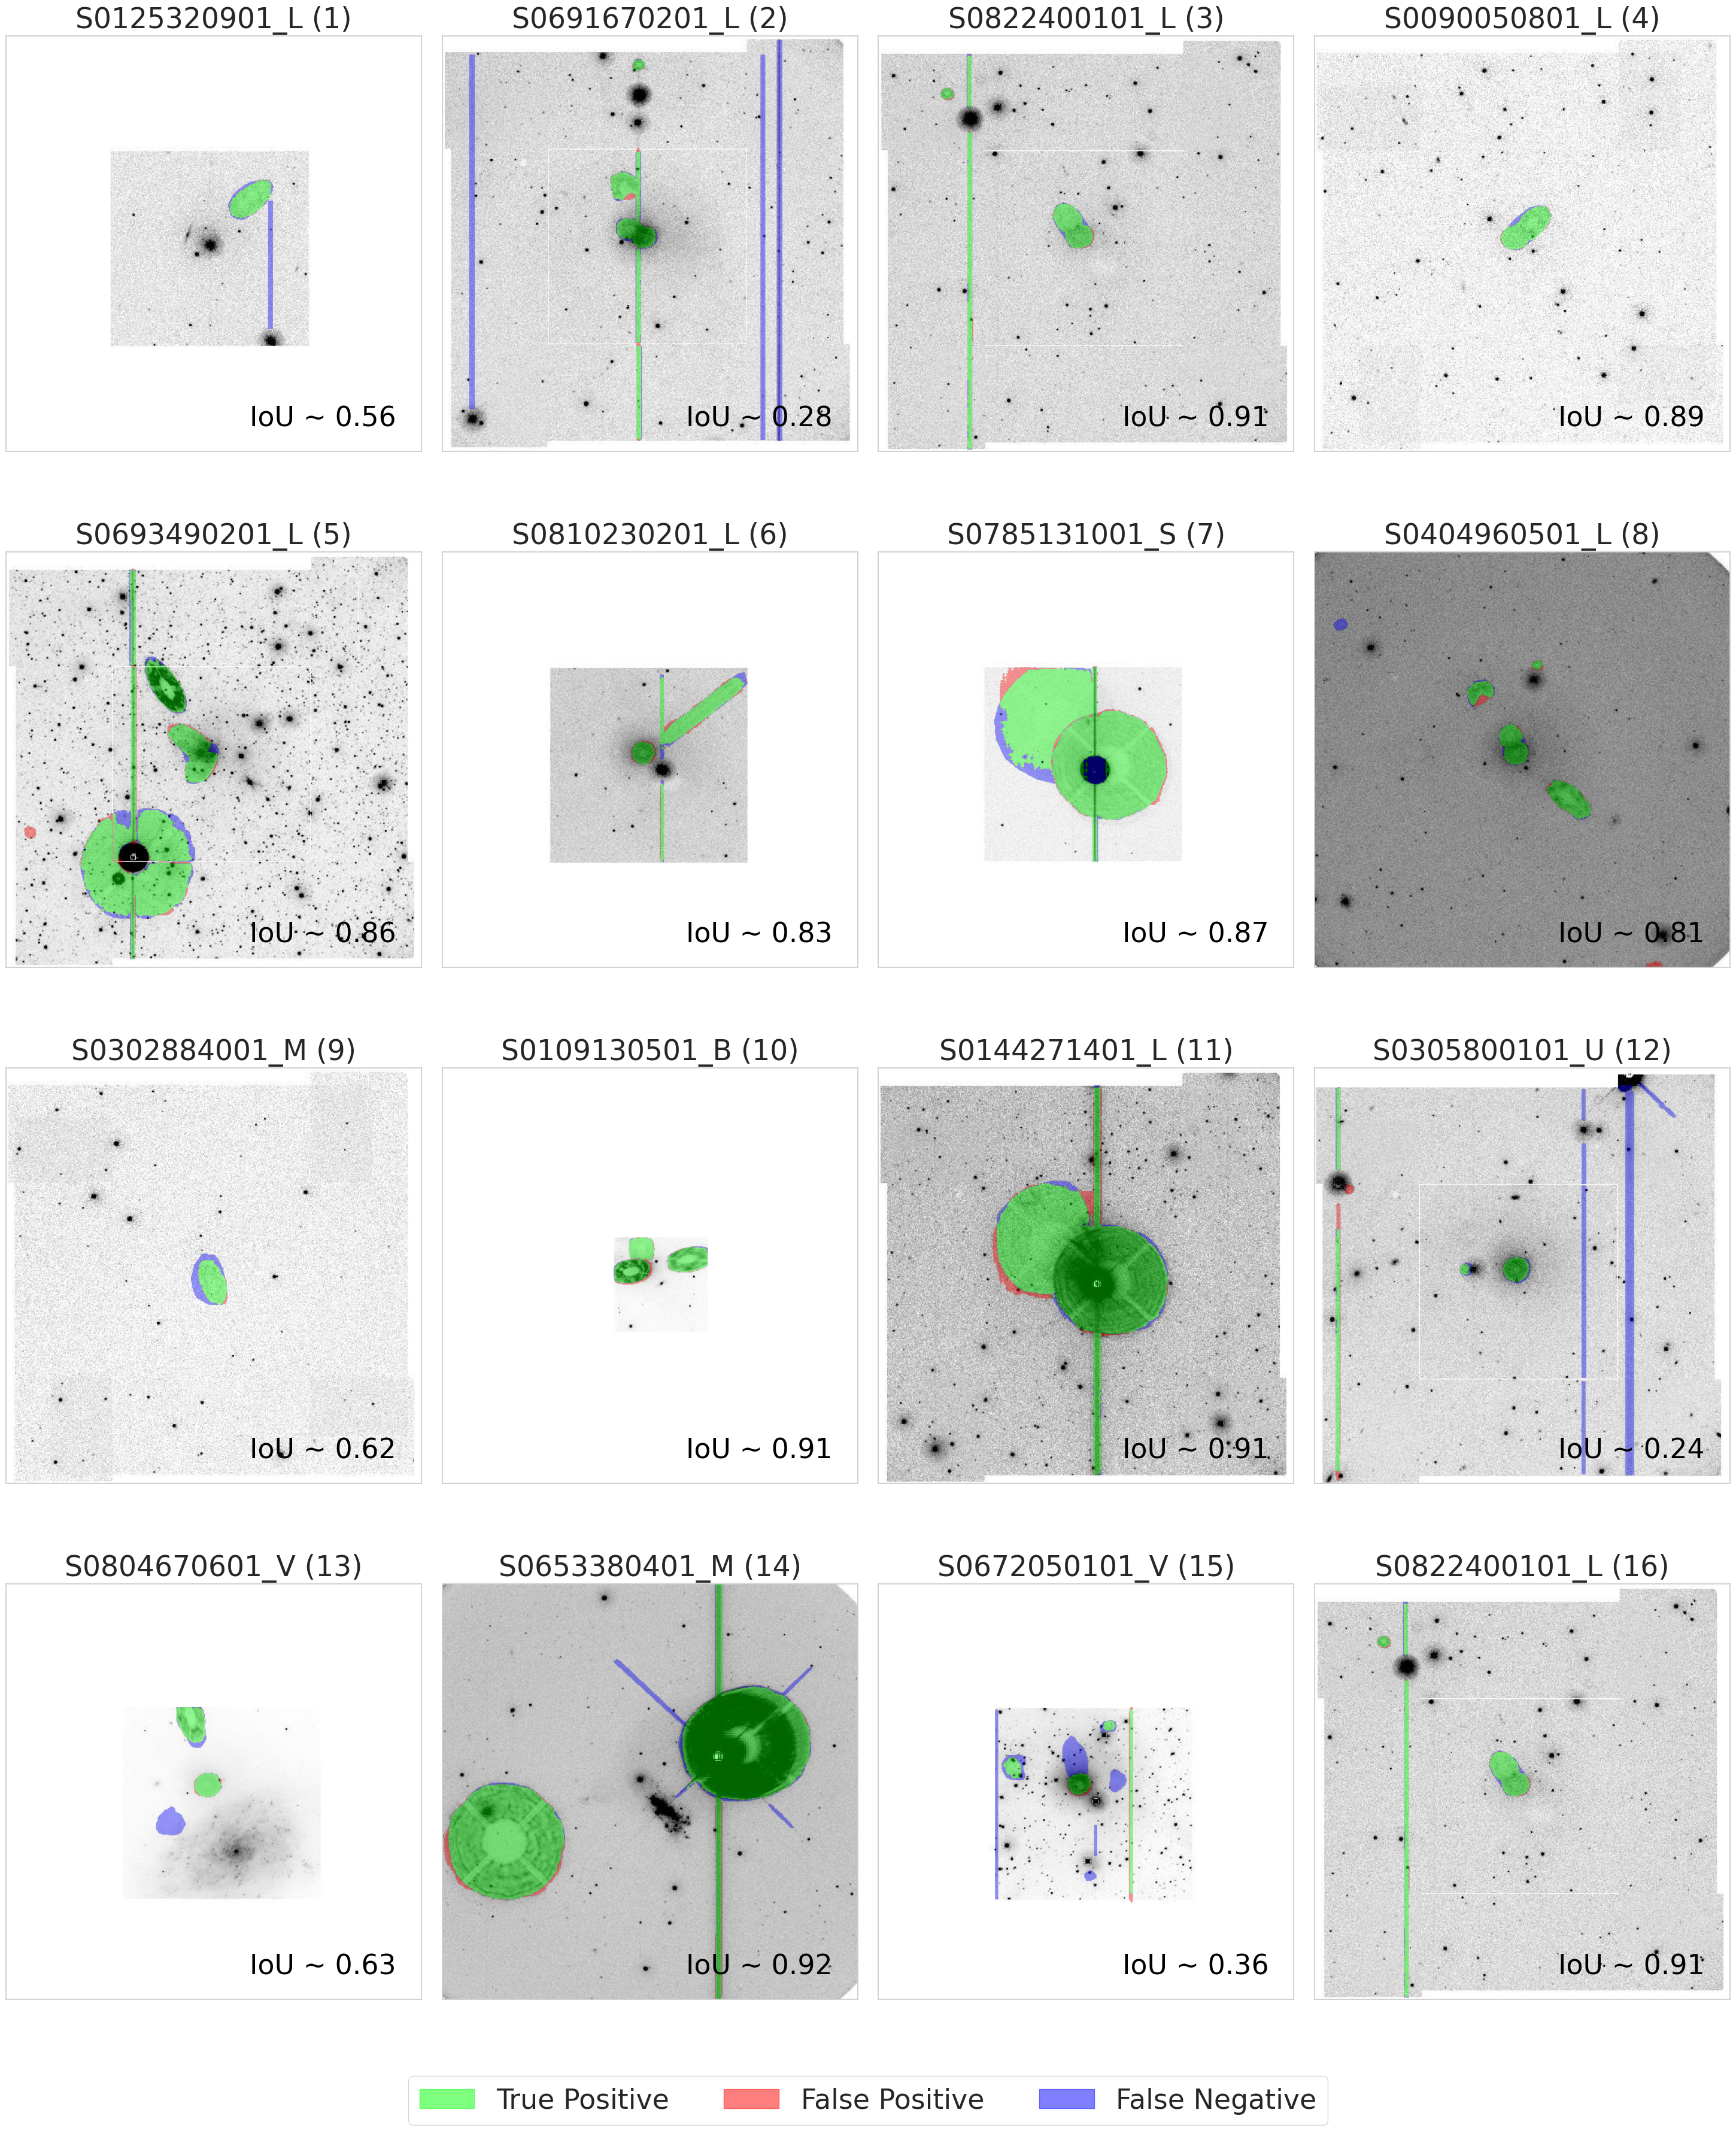

In [85]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2

# Sample data for demonstration (replace with your actual data)
# Assuming pred_images, v_all_preds, valid_coco_data, valid_dir, and dataset_utils are already defined
num_samples = 16
# random_indices = random.sample(range(len(pred_images)), num_samples)
random_indices = [91, 231, 187, 120, 230, 235, 178, 247, 196, 201, 52, 117, 129, 161, 172, 187] 
# random_indices = [52, 92, 3, 46, 109, 158, 64, 79, 88, 104, 117, 129, 161, 172, 187, 200]
images = [pred_images[i] for i in random_indices]
selected_preds = [v_all_preds[i] for i in random_indices]

fig, axes = plt.subplots(4, 4, figsize=(36, 36))

for j, (image_name, pred_mask) in enumerate(zip(images, selected_preds)):
    row, col = divmod(j, 4)
    image_id = [img['id'] for img in valid_coco_data['images'] if img['file_name'].startswith(image_name.split(".")[0])][0]
    dataset_images = valid_coco_data['images']
    image_filename = [dataset_images[i]['file_name'] for i in range(len(dataset_images)) if dataset_images[i]['id'] == image_id][0]
    gt_masks = np.array([dataset_utils.create_mask(valid_coco_data['annotations'][i]['segmentation'][0], (512, 512))
                         for i in range(len(valid_coco_data['annotations']))
                         if valid_coco_data['annotations'][i]['image_id'] == image_id])
    gt_masks = np.array(gt_masks)
    gt_masks = gt_masks[:, None, :, :]

    image = cv2.imread(valid_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax_simple = axes[row, col]
    ax_simple.imshow(255-image)
    ax_simple.set_xticks([])
    ax_simple.set_yticks([])
    ax_simple.set_title(f'{image_name[:13]} ({j+1})', fontsize=34, pad=10)

    # rect = mpatches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=1, edgecolor='gray', facecolor='none')
    # ax_simple.add_patch(rect)

    tp_color = np.array([0, 255, 0, 102]) / 255  # Green with alpha
    fp_color = np.array([255, 0, 0, 102]) / 255  # Red with alpha
    fn_color = np.array([0, 0, 255, 102]) / 255  # Blue with alpha

    true_positive_mask, false_positive_mask, false_negative_mask, iou = metrics_utils.compute_metrics_with_range(gt_masks, pred_mask, image)
    h, w = true_positive_mask.shape[-2:]
    true_positive_mask = true_positive_mask.reshape(h, w, 1) * tp_color.reshape(1, 1, -1)
    false_positive_mask = false_positive_mask.reshape(h, w, 1) * fp_color.reshape(1, 1, -1)
    false_negative_mask = false_negative_mask.reshape(h, w, 1) * fn_color.reshape(1, 1, -1)

    ax_simple.imshow(false_positive_mask)
    ax_simple.imshow(false_negative_mask)
    ax_simple.imshow(true_positive_mask)

    ax_simple.text(300, 480, f'IoU ~ {iou:.2f}', fontsize=33, color='black')

tp_patch = mpatches.Patch(color=tp_color, label='True Positive', alpha=0.5)
fp_patch = mpatches.Patch(color=fp_color, label='False Positive', alpha=0.5)
fn_patch = mpatches.Patch(color=fn_color, label='False Negative', alpha=0.5)

fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='lower center', bbox_to_anchor=(0.5, -0.0003), ncol=3, fontsize=33)
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05, hspace=0.08, wspace=0.05)
plt.savefig('tp_fp_fn_ious.pdf', dpi=600)
plt.show()